In [1]:
import os
import cv2
import py_sod_metrics
from tqdm import tqdm


def cal_metrics(mask_root, pred_root, dataset_name=None):
    results = []

    mask_name_list = sorted(os.listdir(mask_root))
    desc = f"Processing {dataset_name:10s}" if dataset_name else "Processing"
    for mask_name in tqdm(mask_name_list, unit="img", desc=desc):
        WFM = py_sod_metrics.WeightedFmeasure()
        SM = py_sod_metrics.Smeasure()
        EM = py_sod_metrics.Emeasure()
        MAE = py_sod_metrics.MAE()
        mask_path = os.path.join(mask_root, mask_name)
        pred_path = os.path.join(pred_root, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        WFM.step(pred=pred, gt=mask)
        SM.step(pred=pred, gt=mask)
        EM.step(pred=pred, gt=mask)
        MAE.step(pred=pred, gt=mask)

        wfm = WFM.get_results()["wfm"]
        sm = SM.get_results()["sm"]
        em = EM.get_results()["em"]
        meanEm = em["curve"].mean()
        mae = MAE.get_results()["mae"]

        result = {
            "dataset" : dataset_name,
            "image_name": mask_name.replace(".png", ".jpg"),
            "MAE": mae,
            "Smeasure": sm,
            "meanEm": meanEm,
            "wFmeasure": wfm,
            "Sum": 1 - mae + sm + meanEm + wfm,
        }

        results.append(result)

    return results

In [2]:
pred_data_path = "./result_imgs"
test_data_path = "./Dataset/TestDataset"
datasets = ["CAMO", "CHAMELEON", "COD10K", "NC4K"]
results = []
for dataset in datasets:
    pred_root = os.path.join(pred_data_path, dataset)
    mask_root = os.path.join(test_data_path, dataset, "GT")
    iter_results = cal_metrics(mask_root=mask_root, pred_root=pred_root, dataset_name=dataset)
    results.extend(iter_results)

Processing NC4K      : 100%|██████████| 4121/4121 [05:06<00:00, 13.45img/s]


In [3]:
# 把results按照Sum的值输出top5 smallest, 使用堆排序
import heapq
# 先从results使用filter过滤出dataset为CAMO的数据
filtered_results = list(filter(lambda x: x["dataset"] != "NC4K", results))

top5 = heapq.nsmallest(5, filtered_results, key=lambda x: x["Sum"])
for i, item in enumerate(top5):
    print(f"Top {i+1}: {item['dataset']} - {item['image_name']} - {item['Sum']}")

Top 1: CAMO - camourflage_01141.jpg - 1.0696894854014694
Top 2: COD10K - COD10K-CAM-2-Terrestrial-34-Human-2014.jpg - 1.2024691676464159
Top 3: CAMO - camourflage_01170.jpg - 1.5115575906697134
Top 4: COD10K - COD10K-CAM-2-Terrestrial-21-Ant-1233.jpg - 1.5461298312128529
Top 5: COD10K - COD10K-CAM-1-Aquatic-11-Octopus-454.jpg - 1.5857606860672946


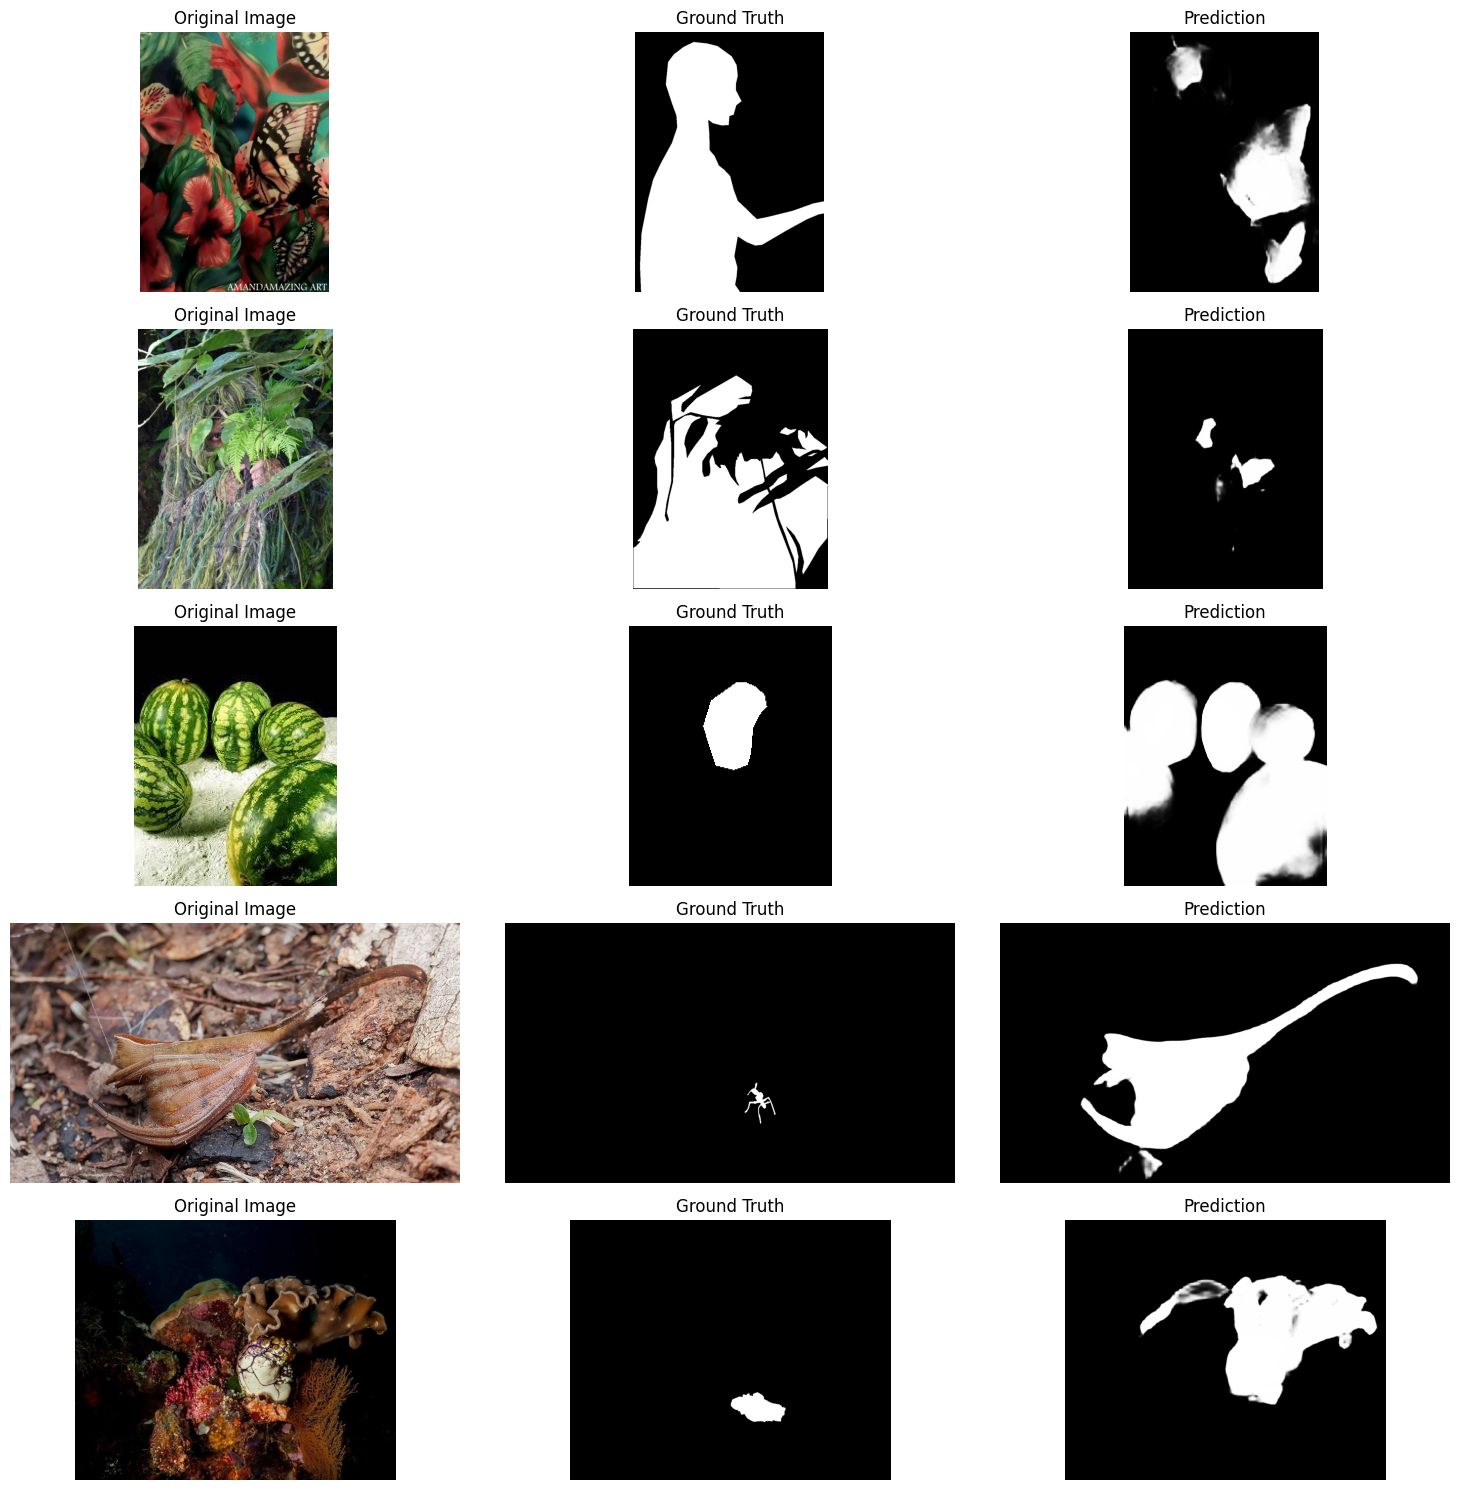

In [4]:
# 打印top5的结果，输出5行，每行3列，分别是原始图片，gt图片，预测图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pred_data_path = "./result_imgs"
test_data_path = "./Dataset/TestDataset"

fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i, item in enumerate(top5):
    img_path = os.path.join(test_data_path, item["dataset"], "Imgs", item["image_name"])
    mask_path = os.path.join(
        test_data_path,
        item["dataset"],
        "GT",
        item["image_name"].replace(".jpg", ".png"),
    )
    pred_path = os.path.join(pred_data_path, item["dataset"], item["image_name"].replace(".jpg", ".png"))

    img = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)
    pred = mpimg.imread(pred_path)

    axs[i, 0].imshow(img)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title("Ground Truth")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(pred, cmap="gray")
    axs[i, 2].set_title("Prediction")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()